In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time


def bspline_wavelet(x, omega, alpha):
    return (
        (1 / 6) * F.relu(omega * x) -
        (4 / 3) * F.relu(omega * x - 0.5) +
        (23 / 6) * F.relu(omega * x - 1) -
        (16 / 3) * F.relu(omega * x - 1.5) +
        (23 / 6) * F.relu(omega * x - 2) -
        (4 / 3) * F.relu(omega * x - 2.5) +
        (1 / 6) * F.relu(omega * x - 3)
    ) * alpha


def bspline_wavelet_optimized(x, omega, alpha):
    ms = torch.tensor([0, 1/6, -7/6, 8/3, -8/3, 7/6, -1/6, 0], dtype=torch.float32) * alpha
    bs = torch.tensor([0, 0, 2/3, -19/6, 29/6, -17/6, 1/2, 0], dtype=torch.float32) * alpha / omega
    sps = torch.arange(7) / (2 * omega)
    y = torch.zeros_like(x)
    for i in range(6):
        mask = (x <= sps[i+1]) & (x > sps[i])
        y = torch.where(mask, ms[i+1] * x + bs[i+1], y)
    return y * omega

In [2]:
# hyperparameters; play around with these
omega = 1
alpha = 1
lower = -1 / omega
upper = 4 / omega
amt = 10**8 # expect to see about 100million MLP queries in NeRF
x = torch.linspace(lower, upper, amt)


t = time.time()
y = bspline_wavelet(x, omega, alpha)
t = time.time() - t
print(f'BSpline default took {t:.6f} seconds')


t = time.time()
y_opt = bspline_wavelet_optimized(x, omega, alpha)
t = time.time() - t
print(f'Optimized version took {t:.6f} seconds')

BSpline default took 1.160858 seconds
Optimized version took 0.825361 seconds


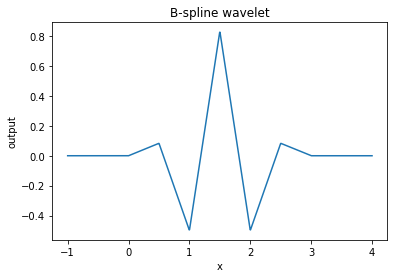

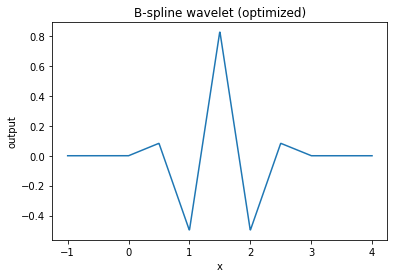

In [3]:
omega = 1
alpha = 1
lower = -1 / omega
upper = 4 / omega
x = torch.linspace(lower, upper, 1000)


y = bspline_wavelet(x, omega, alpha)
plt.plot(x, y)
plt.title('B-spline wavelet')
plt.xlabel('x')
plt.ylabel('output')
plt.show()


y_opt = bspline_wavelet_optimized(x, omega, alpha)
plt.plot(x, y_opt)
plt.title('B-spline wavelet (optimized)')
plt.xlabel('x')
plt.ylabel('output')
plt.show()